In [1]:
# load all the relevant stuff

# eeg analysis libraries
import mne

# import plotting libraries
from matplotlib import pyplot as plt
# python version of ggplot:
from plotnine import *
# https://github.com/sbebo/joypy/blob/master/Joyplot.ipynb
import joypy
import seaborn as sns
#https://github.com/pog87/PtitPrince/blob/master/RainCloud_Plot.ipynb
import PtitPrince  as pt

# numerical libraries
import numpy as np
import pandas as pd
from scipy.sparse import lil_matrix

# import tqdm for a progress bar:
try:
    from tqdm import tqdm_notebook as tqdm
except:
    from tqdm import tqdm

# import file operators
from pathlib import Path
import os
import h5py

# avoid being too verbose
import warnings
mne.set_log_level('ERROR')
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning)

#import autoreject
from autoreject import AutoReject
from functools import partial

/home/richard/anaconda3/envs/py3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [ ]:
# import data and events
from data import raws, events, n
for raw in raws():
    print(raw.info['subject_info'])

In [ ]:
# run analysis across all participants

# length of segments over which analysis is run:
segment_length = 4
conns = []
ar_labels = []
ar_badepochs = []
parproc = 14
for raw, event in tqdm(zip(raws(), events()), total=n):
    print(raw.info['subject_info'])
    original_frequency = raw.info['sfreq']

    # load the raw data
    raw = raw.load_data()
    subid = (raw.info['subject_info']['pid'])
    group = (raw.info['subject_info']['group'])
    
    # create a new virtual channel for the VEOG and HEOG
    veog, _ = raw[mne.pick_channels(raw.ch_names, include=['EXG3', 'EXG4']), :]
    veog = np.diff(veog, axis=0)
    heog, _ = raw[mne.pick_channels(raw.ch_names, include=['EXG1', 'EXG2']), :]
    heog = np.diff(heog, axis=0)
    
    new_info = mne.create_info(['VEOG', 'HEOG'], original_frequency, ch_types='eog')
    raw.info['lowpass'] = new_info['lowpass'] = original_frequency
    new_info['meas_date'] = raw.info['meas_date']
    
    # add these two new channels to the data
    raw = raw.add_channels(
        [mne.io.RawArray(np.concatenate([veog, heog], axis=0), new_info)]
    )
    
    # drop extra channels (not used)
    raw = raw.drop_channels(['EXG7', 'EXG8'])
    # resample the data (w/ parallel processing)
    raw = raw.resample(256, n_jobs = parproc)


    # set the average of the mastoids as reference
    raw = raw.set_eeg_reference()
    raw = raw.apply_proj()
        
    # filter the EOG data
    raw = raw.filter(0.5, 15, picks=mne.pick_types(raw.info, eeg=False, eog=True), n_jobs=6, verbose=False)
    # filter the EEG data (bandstop for mains and all harmonics)
    raw = raw.notch_filter(np.arange(50, raw.info['lowpass'], 50), n_jobs=6, verbose=False)
    # high-pass filter the data
    raw = raw.filter(0.5, 45, n_jobs=parproc, verbose=False)
        
#     # Run ICA
#     # -------  
#     print('Subject ICA ID: {subid}'.format(subid=subid))
    
#     ica_file = 'data/interim/{subid}-ica.fif.gz'.format(subid=subid)
#     # the following is only run if no ICA is present so far
#     if not os.path.isfile(ica_file):
#         # run an ICA to remove components correlated with both horizontal and vertical EOG traces
#         seed = np.random.RandomState(2017)
#         ica = mne.preprocessing.run_ica(raw, n_components=0.99, max_pca_components=64,
#                                         random_state=seed, eog_ch=['HEOG', 'VEOG'],
#                                         picks=mne.pick_types(raw.info, eeg=True))
#         # save ICA to .fif file
#         ica.save(ica_file)
#     else:
#         ica = mne.preprocessing.read_ica(ica_file)

#     # plot the components to be excluded:
#     ica.plot_components(picks=ica.exclude, title=subid, colorbar=True)
#     # apply the ICA correction:
#     raw = ica.apply(raw)

    
    
    # Epoch the data
    # --------------
    # edit the event structure to chop into 4s segments:
    sample_frequency = raw.info['sfreq']
    starttimes = event[(1, 3), 0] // (original_frequency / sample_frequency)
    event = np.stack([
        np.concatenate([np.arange(time + (segment_length / 2) * sample_frequency,
                                  time + (60 - segment_length / 2) * sample_frequency,
                                  segment_length * sample_frequency,
                                  dtype=int)
                        for time in starttimes]),
        np.zeros((60 - segment_length) // 2, dtype=int),
        102 + np.zeros((60 - segment_length) // 2, dtype=int)
    ], axis=1)
    
    # epoch the data to include only eyes closed:
    epochs = mne.Epochs(raw, event, event_id={'eyes closed': 102}, tmin=0, tmax=segment_length, preload=True)
    
    
    # autoreject bad epochs
    # ---------------------
    np.random.seed(42)
    ar = AutoReject(n_jobs=parproc, verbose=False)
    ar.fit(epochs)
    epochs_clean, rl = ar.transform(epochs, return_log=True)

#     # check data after  preprocessing
#     epochs_clean.plot(n_channels=64, scalings={'eeg': 10e-5})
#     plt.show()

    print("{:.2f}% epochs rejected (N={})".format(
          epochs_clean.drop_log_stats(), len(epochs_clean)))
    ar_labels.append(rl.labels)
    ar_badepochs.append(rl.bad_epochs)

    # Connectivity analysis
    # ---------------------
    connectivity_file = 'Output/{subgroup}_{subid}_conn.csv'.format(subid=subid, subgroup=group)
    if not os.path.isfile(connectivity_file):
        picks = mne.pick_types(epochs_clean.info, eeg=True)
        connection_pairs = mne.connectivity.seed_target_indices(picks, picks)
        
        # which frequency bands to use:
        freqbands = {'theta': (4, 8), 'alpha': (8, 14), 'beta': (14, 30), 'gamma': (30, 60)}
        fmin = np.array([f for f, _ in freqbands.values()])
        fmax = np.array([f for _, f in freqbands.values()])
        
        # perform the connectivity analysis:
        conn, freqs, times, n_epochs, n_tapers = mne.connectivity.spectral_connectivity(
            epochs_clean, method='wpli', mode='multitaper', fmin=fmin, fmax=fmax, faverage=True,
            indices=connection_pairs, n_jobs=parproc, verbose=False
        )
        conns.append(conn)
        
        # save individual arrays of each subject (there is probably a better way than to go via numpy to pandas to save this...)
        pd.DataFrame(
            dict(channel_1=connection_pairs[0], channel_2=connection_pairs[1],
                 **{key: conn[:, idx] for idx, key in enumerate(freqbands.keys())})
        ).to_csv(connectivity_file)

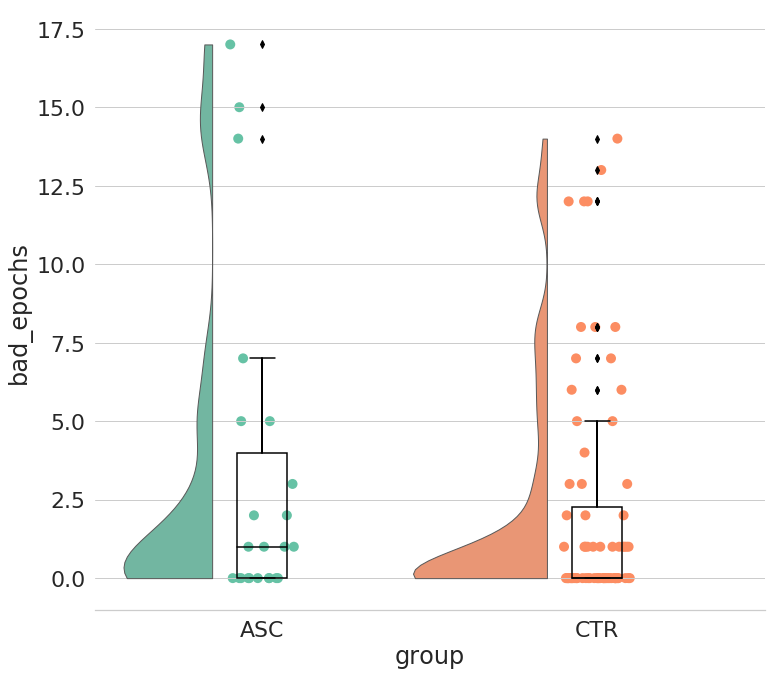

In [52]:
# QC of bad epochs

if os.path.isfile('Output/subjects.h5'):
    subjects = pd.read_hdf('Output/subjects.h5', 'subjects')
else:
    subj = []
    grps = []
    bads = []
    epch = []
    for s_idx, raw in enumerate(raws()):
        subj.append(raw.info['subject_info']['pid'])
        grps.append(raw.info['subject_info']['group'])
        bads.append(ar_badepochs[s_idx].sum())
        epch.append(len(ar_badepochs[s_idx]))

    subjects = pd.DataFrame(np.column_stack([subj, grps, bads, epch]),
                            columns=['subject', 'group', 'bad_epochs', 'tot_epochs'])

    subjects.bad_epochs = subjects.bad_epochs.astype(int)
    subjects.tot_epochs = subjects.tot_epochs.astype(int) 
    subjects.to_hdf('Output/subjects.h5', key='subjects', mode='w')

sns.set(style="whitegrid",font_scale=2)

f, ax = plt.subplots(figsize=(12, 11))
dy = "bad_epochs"; dx = "group"; ort = "v"
# Draw a violinplot with a narrower bandwidth than the default
ax=pt.half_violinplot(data = subjects, palette = "Set2", bw=.2,  linewidth=1,cut=0.,\
                   scale="area", width=.8, inner=None,orient=ort,x=dx,y=dy)
ax=sns.stripplot(data = subjects, palette="Set2", edgecolor="white",size=10,orient=ort,\
                 x=dx,y=dy,jitter=1,zorder=0)
ax=sns.boxplot(data = subjects, color="black",orient=ort,width=.15,x=dx,y=dy,zorder=10,\
              showcaps=True,boxprops={'facecolor':'none', "zorder":10},\
               showfliers=True,whiskerprops={'linewidth':2, "zorder":10},saturation=1)
sns.despine(left=True)

In [55]:
# Sensor mapping for connectivity measures & data saving
A = mne.channels.find_ch_connectivity(raw.info, ch_type='eeg')
if os.path.isfile('Output/processed_results.h5'):
    hf = h5py.File('Output/processed_results.h5', 'r')
    vectconn = hf['vectconn']
    frequencies_labels = [l.astype(str) for l in hf['frequencies_labels']]
    electrodes = hf['electrodes']
    idx = hf['idx']
    ar_badepochs = hf['ar_badepochs']
else:
    bin=0
    idx = []
    electrodes = []
    for e1 in range(64):
        for e2 in range(64):
            if e2>e1:
                idx.append(bin)
                electrodes.append((e1, e2))
            bin = bin + 1

    frequencies_labels = ['theta', 'alpha', 'beta', 'gamma']
    vectconn = np.zeros([len(conns), len(frequencies_labels), len(idx)])
    for f_idx, f_lab in enumerate(frequencies_labels):
        for s_idx, s_conn in enumerate(conns):
            vectconn[s_idx, f_idx, :] = s_conn[idx, f_idx]
    hf = h5py.File('Output/processed_results.h5', 'w')
    hf.create_dataset('vectconn', data=vectconn)
    hf.create_dataset('frequencies_labels', data=np.array(frequencies_labels, dtype='S'))
    hf.create_dataset('electrodes', data=electrodes)
    hf.create_dataset('idx', data=idx)
    hf.create_dataset('ar_badepochs', data=ar_badepochs)
    #hf.create_dataset('subjects', data=subjects)    
    hf.close()

<Figure size 1296x1008 with 0 Axes>

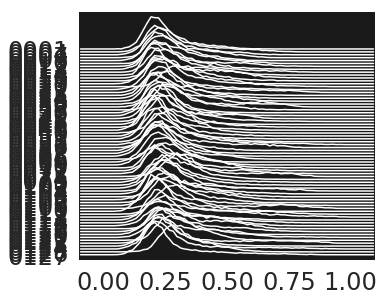

<Figure size 576x288 with 0 Axes>

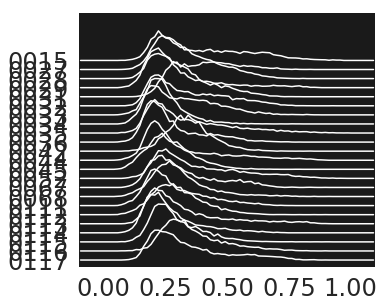

In [58]:
# Connectivity measures Joyplots

subj = []
grps = []
freq = []
vals = []
for f_idx, f_lab in enumerate(frequencies_labels):
    for s_idx, raw in enumerate(raws()):
        subj.append([raw.info['subject_info']['pid']]*2016)
        grps.append([raw.info['subject_info']['group']]*2016)
        freq.append([f_lab]*2016)
        vals.append(vectconn[s_idx, f_idx])

flatten = lambda l: [item for sublist in l for item in sublist]
        
subj = flatten(subj)
grps = flatten(grps)
freq = flatten(freq)
vals = flatten(vals)

df = pd.DataFrame(np.column_stack([subj, grps, freq, vals]),
                  columns=['subject', 'group', 'frequency', 'wPLI'])

df.wPLI = df.wPLI.astype(float) 

plt.figure(figsize=(8,4))
joypy.joyplot(df.loc[df.group=='CTR'], column="wPLI", by=["subject"],
              fill=False, background='k', linecolor="w",
              legend=False, overlap=0.5, figsize=(6,5),kind="counts",
              x_range=[-0.1,1.1], bins=80)
plt.figure(figsize=(8,4))
joypy.joyplot(df.loc[df.group=='ASC'], column="wPLI", by=["subject"],
              fill=False, background='k', linecolor="w",
              legend=False, overlap=0.5, figsize=(6,5),kind="counts",
              x_range=[-0.1,1.1], bins=80)
plt.show()

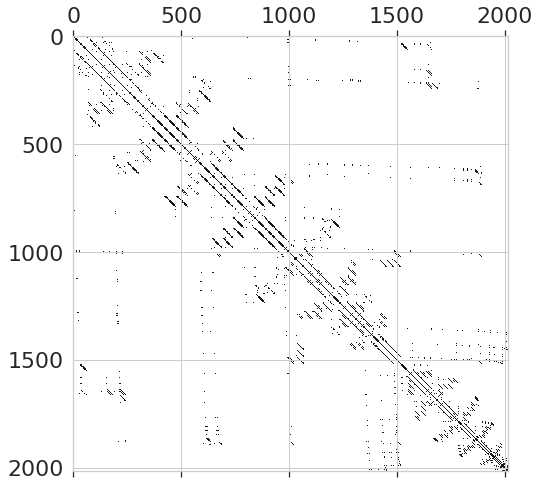

In [59]:
# Metaconnectivity for cluster permutation of bivariate measurements

if os.path.isfile('Output/metaconn.h5'):
    hf = h5py.File('Output/metaconn.h5', 'r')
    metaconn = hf['metaconn']
else:
    metaconn = np.zeros((vectconn.shape[-1], vectconn.shape[-1]))

    for ne1, (e11,e12) in tqdm(enumerate(electrodes)):
        for ne2, (e21,e22) in enumerate(electrodes):
            # print(ne1,e11,e12,ne2,e21,e22)
            metaconn[ne1, ne2] = (((A[0][e11,e21]) and (A[0][e12,e22])) or 
                                  ((A[0][e11,e22]) and (A[0][e12,e21])) or
                                  ((A[0][e11,e21]) and (e12 == e22)) or 
                                  ((A[0][e12,e21]) and (e11 == e22)) or
                                  ((A[0][e11,e22]) and (e12 == e21)) or 
                                  ((A[0][e12,e22]) and (e11 == e21)))

    hf = h5py.File('Output/metaconn.h5', 'w')
    hf.create_dataset('metaconn', data=metaconn)
    hf.close()

plt.figure(figsize=[10,8])
plt.spy(metaconn)
plt.show()

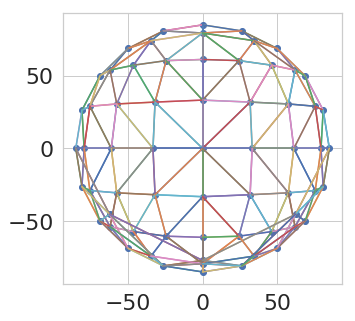

In [60]:
# Check sensors neighborood
sensloc = np.array([c['loc'][:3] for c in raw.info['chs']][:64])
plt.figure(figsize=[5,5])
plt.scatter(sensloc[:, 0], sensloc[:, 1])
for e1 in range(64):
    for e2 in range(64):
        if A[0][e1,e2]:
            plt.plot((sensloc[e1, 0], sensloc[e2, 0]), (sensloc[e1, 1], sensloc[e2, 1]))

theta
alpha
beta
gamma


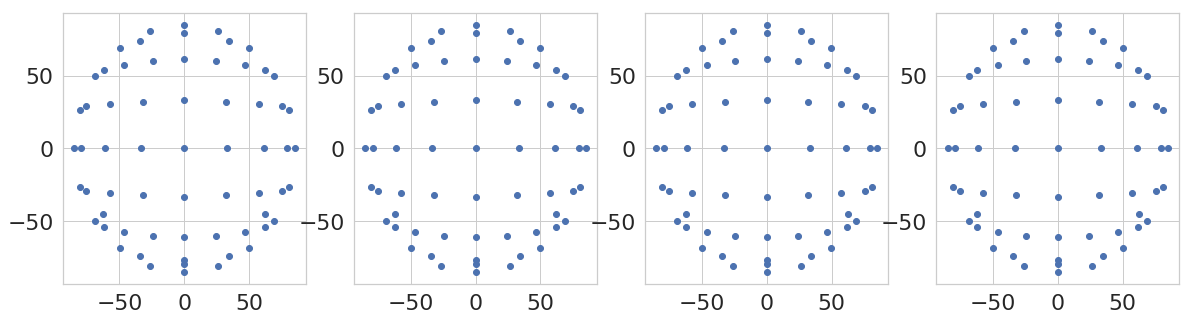

In [61]:
# Analyses & visualization of connectivity modulation clusters

grps = np.zeros(vectconn.shape[0])
for s_idx, raw in enumerate(raws()):
    if raw.info['subject_info']['group']=='ASC':
        grps[s_idx] = 1
        
plt.figure(figsize=[20,5])
for f_idx, f_lab in enumerate(frequencies_labels):
    print(f_lab)
    data1 = vectconn[np.argwhere(grps==1), f_idx, :]
    data2 = vectconn[np.argwhere(grps==0), f_idx, :]
    Fobs, clusters, cluster_pv, H0 = mne.stats.permutation_cluster_test(X=[data1, data2], n_permutations=1024, connectivity=lil_matrix(metaconn))
    plt.subplot(1,4,f_idx+1)
    plt.scatter(sensloc[:, 0], sensloc[:, 1])
    if len(cluster_pv)>0:
        print(cluster_pv)
        for cl_idx, cluster in enumerate(clusters):  # [np.argmin(cluster_pv)]
            #if cluster_pv[cl_idx]<0.05:
            color = np.random.rand(3)
            for ne, (e1,e2) in enumerate(electrodes):
                if cluster[ne]:
                    print(cl_idx, e1, e2, Fobs[ne])
                    plt.plot((sensloc[e1, 0], sensloc[e2, 0]), (sensloc[e1, 1], sensloc[e2, 1]), linewidth=5, color=color)
            plt.title(f_lab)

In [62]:
# Graph theory sandbox
import networkx as nx
# Convert flatten connectivity matrix into square shape
# Also compute graph measures on the fly

result = np.zeros((vectconn.shape[0], vectconn.shape[1], 64, 64))
for f_idx, f_lab in enumerate(frequencies_labels):
    for s_idx, row in enumerate(subjects.iterrows()):
        tmp = np.zeros((64, 64))
        ind = np.triu_indices(64,1)
        tmp[ind] = vectconn[s_idx,f_idx,:]
        tmp = tmp + tmp.T
        result[s_idx, f_idx, :, :] = tmp
        
        G = nx.from_numpy_array(tmp)
        T = nx.minimum_spanning_tree(G, weight = 'weight')

        threshold = np.sort(tmp.flatten())[int(len(tmp.flatten())*0.9)]
        for e in G.edges(data=True):
            if e[2]['weight']>threshold:
                T.add_edge(e[0], e[1], weight=e[2]['weight'])
        
        subjects.loc[row[0], 'assortativity_'+f_lab] = nx.degree_pearson_correlation_coefficient(T)
        subjects.loc[row[0], 'clustering_'+f_lab] = nx.average_clustering(T)
        subjects.loc[row[0], 'avg_shortest_path_'+f_lab] = nx.average_shortest_path_length(T)

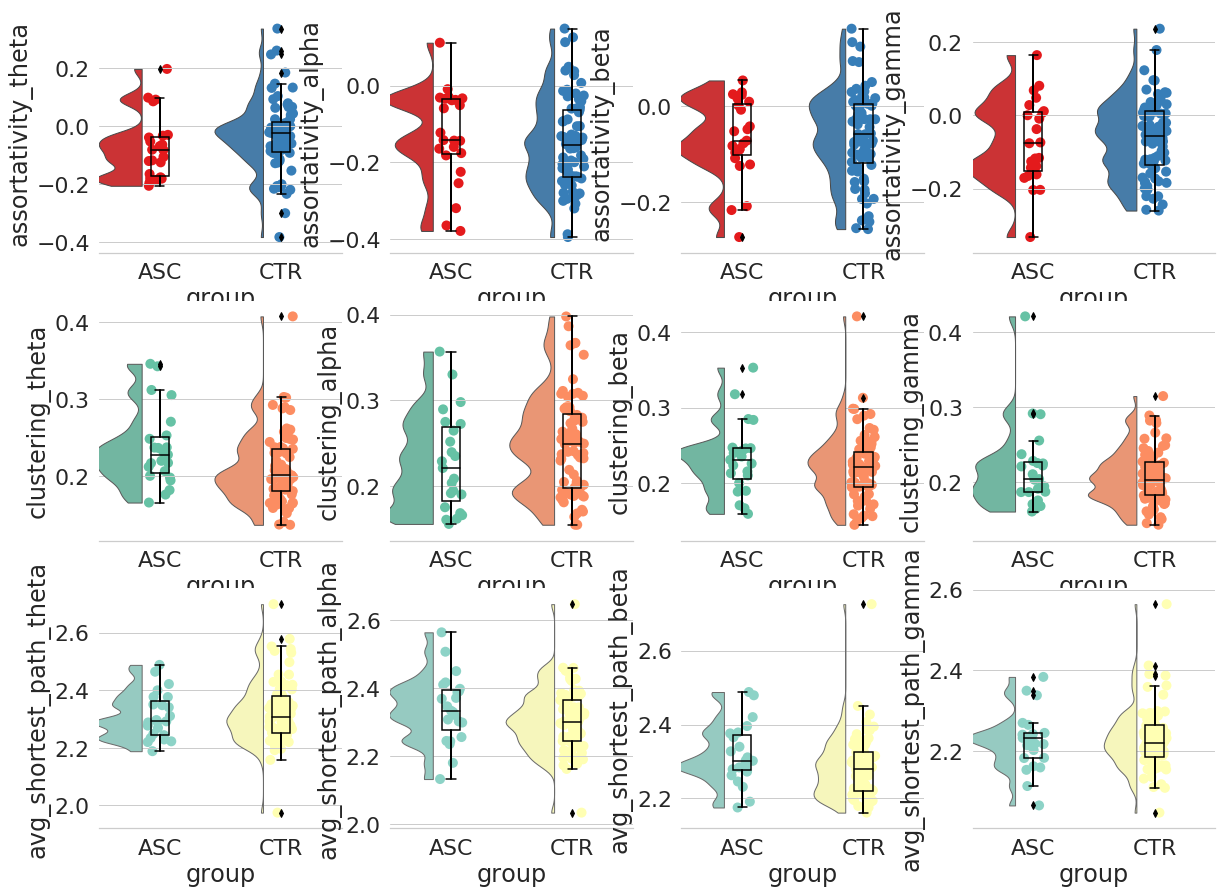

In [63]:
plt.figure(figsize=[20, 15])
bin=1
for m_idx, m_lab in enumerate(['assortativity', 'clustering', 'avg_shortest_path']):
    for f_idx, f_lab in enumerate(frequencies_labels):
        plt.subplot(3, 4, bin)
        dy = m_lab + "_" + f_lab; dx = "group"; ort = "v"
        pt.half_violinplot(data = subjects, palette = "Set" + str(m_idx+1), bw=.2,  linewidth=1,cut=0.,\
                           scale="area", width=.8, inner=None,orient=ort,x=dx,y=dy)
        sns.stripplot(data = subjects, palette="Set" + str(m_idx+1), edgecolor="white",size=10,orient=ort,\
                         x=dx,y=dy,jitter=1,zorder=0)
        sns.boxplot(data = subjects, color="black",orient=ort,width=.15,x=dx,y=dy,zorder=10,\
                      showcaps=True,boxprops={'facecolor':'none', "zorder":10},\
                       showfliers=True,whiskerprops={'linewidth':2, "zorder":10},saturation=1)
        sns.despine(left=True)
        bin = bin+1